In [1]:
import pandas as pd

In [2]:
patch_responses = pd.read_csv("df_pd_final.csv")

In [3]:
patch_responses.head()

,cluster_id,patch_id,responses.message,responses.resp_msg_id,responses.parent,upstream
0,0,<000000000000a94981058d37f1a4@google.com>,NaN,NaN,NaN,NaN
1,0,<000000000000a94981058d37f1a4@google.com>,b'Return-Path: <SRS0=Cx4R=VG=vger.kernel.org=n...,<CAEf4BzYTGuXgN+vNJEoMbH_GFAVnSsBvq_YhvoFOeGG5...,<000000000000a94981058d37f1a4@google.com>,NaN
2,0,<000000000000a94981058d37f1a4@google.com>,b'Return-Path: <SRS0=gj9M=VG=vger.kernel.org=l...,<CAEf4BzYTGuXgN+vNJEoMbH_GFAVnSsBvq_YhvoFOeGG5...,<000000000000a94981058d37f1a4@google.com>,NaN
3,0,<000000000000a94981058d37f1a4@google.com>,b'Return-Path: <xdp-newbies-owner@vger.kernel....,<CAEf4BzYTGuXgN+vNJEoMbH_GFAVnSsBvq_YhvoFOeGG5...,<000000000000a94981058d37f1a4@google.com>,NaN
4,0,<000000000000a94981058d37f1a4@google.com>,b'Return-Path: <intel-wired-lan-bounces@osuosl...,<CAEf4BzabgRE6qZChfw=7nptxYAyZFcj0+Jk_PMSZQP0Z...,<000000000000a94981058d37f1a4@google.com>,NaN


In [7]:
response_counts = patch_responses.groupby('upstream').nunique('responses.resp_msg_id')[['responses.resp_msg_id']].reset_index()

In [12]:
response_counts[response_counts['responses.resp_msg_id'] == 0][['upstream']].to_csv('no_responsev5.4..v5.5.csv', index=False)

In [3]:
from ast import literal_eval

def try_literal_eval(s):
    try:
        return literal_eval(s).decode()
    except:
        return None
    
patch_responses['responses.message'] = patch_responses['responses.message'].apply(try_literal_eval)
patch_responses = patch_responses.where(pd.notnull(patch_responses), None)

In [4]:
import email

from pypasta.Repository.Mbox import PatchMail

def get_tags(message, tag_name):
    try:
        mail = email.message_from_string(message)
        return PatchMail(mail, mail['Message-Id']).tags[tag_name]
    except:
        return None
    
def get_author(message):
    try:
        mail = email.message_from_string(message)
        return PatchMail(mail, mail['Message-Id']).author
    except:
        return None

def get_payload(message):
    try:
        return email.message_from_string(message).get_payload()
    except:
        return None
    
def get_header(message, header):
    try:
        return email.message_from_string(message)[header]
    except:
        return None

In [5]:
patch_responses['response_author'] = patch_responses['responses.message']\
                                .apply(lambda message: get_header(message, 'From'))

Total number of email responses that were filtered out:

In [6]:
patch_responses[patch_responses['response_author'].str.contains("-bot", na = True)]['response_author']\
                .count()

6903

In [7]:
patch_responses = patch_responses[~ patch_responses['response_author'].str.contains("-bot", na = True)]

In [8]:
def try_reduce(item):
    try:
        return item[0]
    except:
        return None

patch_responses['author'] = patch_responses['responses.message']\
                                .apply(lambda bytes_array: try_reduce(get_tags(bytes_array, 'signed-off-by')))

Signed-off-by is the most consistently used tag considering each mail. This is used to determine the original author of patches in emails. Only the first Signed-off-by tag is used since these tags increase as patches evolve.

In [9]:
patch_responses['reviewed-by'] = patch_responses['responses.message']\
                                .apply(lambda bytes_array: get_tags(bytes_array, 'reviewed-by'))

In [10]:
cols = list(patch_responses.columns)
cols.remove('reviewed-by')
patch_responses_long = patch_responses.set_index(cols)

In [11]:
patch_responses_long = pd.melt(patch_responses_long['reviewed-by'].apply(pd.Series).reset_index(), 
            id_vars=cols,
            value_name='reviewed-by').sort_index()
patch_responses_long.drop('variable', axis=1, inplace=True)

Number of unique developers and reviewers that are in tha dataset:

In [12]:
patch_responses_long[['author', 'reviewed-by']].nunique()

author         3293
reviewed-by     931
dtype: int64

Total number of developer and reviewer emails that are in tha dataset:

In [13]:
patch_responses_long[['author', 'reviewed-by']].count()

author         511790
reviewed-by     22364
dtype: int64

In [14]:
patch_responses_long.to_csv('df_with_tags.csv')

A very small portion of the response emails are coming from reviewers.

In [15]:
from scipy import stats
import matplotlib.pyplot as plt

##### Number of email responses of each Developer for all patches included in some fixed release, e.g., v5.5


In [16]:
response_counts = patch_responses[['author','responses.resp_msg_id']]\
                    .groupby('author')\
                    .nunique()['responses.resp_msg_id']\
                    .reset_index()\
                    .sort_values('responses.resp_msg_id', ascending=False)
# response_counts.head()

The developers who receieved the most responses

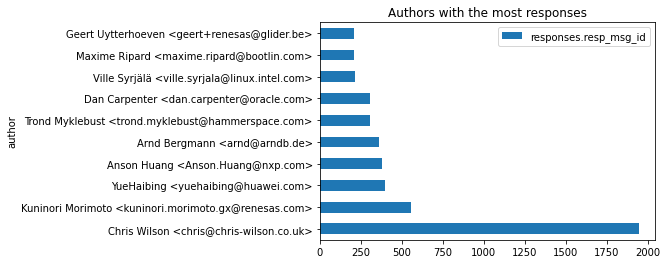

In [17]:
ax = response_counts[:10].plot(x = 'author', title = 'Authors with the most responses', kind = 'barh')
ax.figure.savefig('authors_most_responses.png', dpi=1000, bbox_inches = "tight")

In [18]:
del response_counts

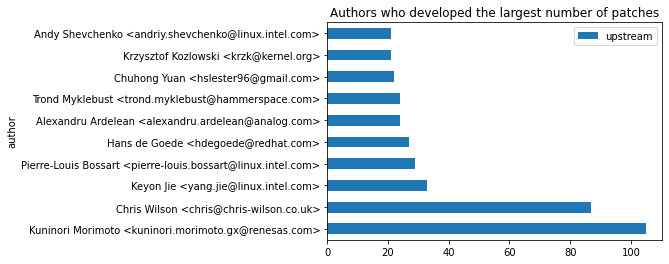

In [19]:
ax = patch_responses[['author','upstream']].groupby('author')\
                .nunique()['upstream']\
                .reset_index('author')\
                .sort_values('upstream', ascending=False)\
                .head(10)\
                .plot(title = 'Authors who developed the largest number of patches', kind = 'barh', x = 'author')
ax.figure.savefig('authors_most_commits.png', dpi=1000, bbox_inches = "tight")

Above are the top 20 authors who has been associated with the largest number of distinct upstream commits. Authors are extracted from emails. The first signed-off-by tag in each email is assumed to be the author/developer of the patch discussed in that email.

#### Number of Reviewed-by of each Developer (in some fixed release)

In [20]:
review_counts = patch_responses_long[['author', 'reviewed-by', 'responses.resp_msg_id']]\
                    .groupby('author')\
                    .count()['reviewed-by']\
                    .reset_index()\
                    .sort_values('reviewed-by', ascending=False)
review_counts.head()

,author,reviewed-by
519,Chris Wilson <chris@chris-wilson.co.uk>,633
939,Geert Uytterhoeven <geert+renesas@glider.be>,507
291,Arnd Bergmann <arnd@arndb.de>,288
2070,Nathan Chancellor <natechancellor@gmail.com>,257
1268,Jean-Philippe Brucker <jean-philippe@linaro.org>,215


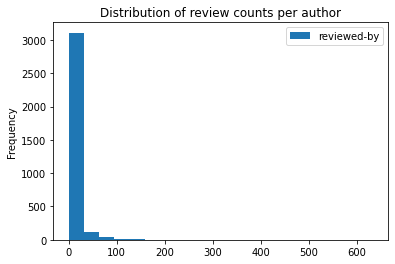

In [21]:
ax = review_counts.plot(x = 'author', title = 'Distribution of review counts per author', kind = 'hist', bins = 20)
ax.figure.savefig('authors_review_distribution.png', dpi=1000, bbox_inches = "tight")

Above is the distribution of the amout of review emails each developer receive. Data is divided into 20 bins. Nevertheless, it can be seen that a large percentage of the developers received a small amount of reviews.

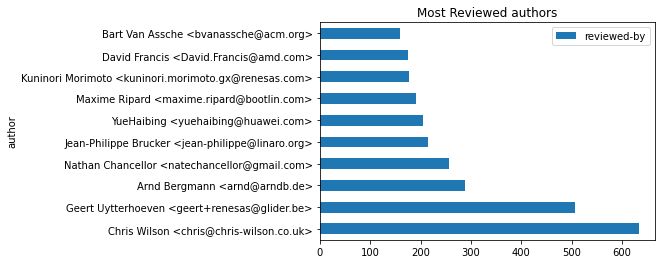

In [22]:
ax = review_counts[:10].plot(x = 'author', title = 'Most Reviewed authors', kind = 'barh')
ax.figure.savefig('authors_most_reviews.png', dpi=1000, bbox_inches = "tight")

Above are the top 10 authors who has received the largest number of review emails. For these counts, every email which has a Reviewed-by tag is considered a review.

In [23]:
del review_counts

#### Compare number of Reviewed-by vs. email responses per patch
(Is there a correlation on patch basis? E.g., more email responses, more Reviewed-by tags?)

In [24]:
patches_emails = patch_responses_long\
                    .groupby('upstream')\
                    .nunique()['responses.resp_msg_id']
patches_reviews = patch_responses_long[['upstream', 'responses.resp_msg_id', 'reviewed-by']]\
                    .groupby('upstream')\
                    .count()['reviewed-by']

patches = pd.concat([patches_reviews, patches_emails], axis=1, sort=False)
patches.head()

,reviewed-by,responses.resp_msg_id
upstream,,
001b83d395ab2acfddc46b73376f8dbdece89af7,0,7
00222d1394104f0fd6c01ca9f578afec9e0f148b,0,1
00265bee100299f01563717927548d9c99a9dd44,0,4
0033b34a03ec5cf747cdaf9b1f9dceb91c020f17,0,2
004e822a6faa807f4413ac066fa29ea433550070,0,13


In [25]:
patches[['responses.resp_msg_id', 'reviewed-by']].corr()

,responses.resp_msg_id,reviewed-by
responses.resp_msg_id,1.000000,0.748392
reviewed-by,0.748392,1.000000


In [26]:
del patches_emails 
del patches_reviews

Here I investigate whether there is a correlation between the number of emails involved in the discussion for each upstream commit and the number of reviews (that is, again, the number of emails including reviewed by tags) made for during the evaluation of that commit

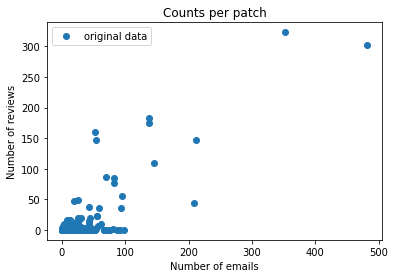

In [27]:
slope, intercept, r_value, p_value, std_err = stats.linregress(patches['responses.resp_msg_id'],
                                                               patches['reviewed-by'])

plt.plot(patches['responses.resp_msg_id'],patches['reviewed-by'], 'o', label='original data')
# plt.plot(patches['responses.resp_msg_id'], 
#          intercept + slope*patches['responses.resp_msg_id'], 
#          'r', 
#          label='fitted line')

plt.xlabel('Number of emails')
plt.ylabel('Number of reviews')
plt.title('Counts per patch')

fig1 = plt.gcf()
fig1.savefig('review_to_reponse_peresponse_to_email_patch.png', dpi=1000, bbox_inches = "tight")

plt.legend()
plt.show()

In the graph above, each dot represents an upstream commit. Number of emails involved in the discussion about each commit and the number of reviews are shown in the horizontal and vertical axes, respectively. 

In [28]:
del patches

#### Compare number of Reviewed-by vs. email responses per author 
(Do Reviewed-by tags and number of emails generally correlate among authors?)

What is the Reviewed-by to email responses ratio per author? Is this distribution of ratio concentrated around one value (there is "one common ratio preference among developers"), equally distributed in the scale (everyone has a different preference of use), or clustered among the scale (there are different parties of preference).

In [29]:
authors_emails = patch_responses_long\
                    .groupby('author')\
                    .nunique()['responses.resp_msg_id']
authors_reviews = patch_responses_long\
                    .groupby('author')\
                    .count()['reviewed-by']

authors = pd.concat([authors_reviews, authors_emails], axis=1, sort=False)
authors.head()

,reviewed-by,responses.resp_msg_id
author,,
"""Eric W. Biederman"" <ebiederm@xmission.com>",24,55
"""Huang, Ying"" <ying.huang@intel.com>",8,5
"""Lee, Chun-Yi"" <jlee@suse.com>",0,1
"""Mauro S. M. Rodrigues"" <maurosr@linux.vnet.ibm.com>",18,6
"""Yan, Zheng"" <zyan@redhat.com>",20,32


In [30]:
del authors_emails 
del authors_reviews

This ratio probably doesn't mean too much, but we do know that there's a significant corr between 'responses.resp_msg_id', 'reviewed-by'. What to do with them?

#### Does many responses mean many reviews (per author)?

In [31]:
authors[['responses.resp_msg_id', 'reviewed-by']].corr()

,responses.resp_msg_id,reviewed-by
responses.resp_msg_id,1.000000,0.689379
reviewed-by,0.689379,1.000000


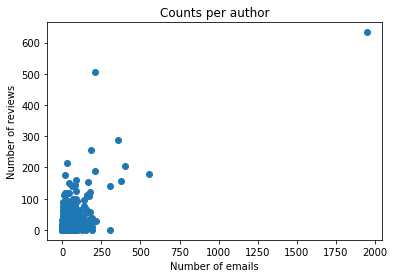

In [32]:
slope, intercept, r_value, p_value, std_err = stats.linregress(authors['responses.resp_msg_id'],
                                                               authors['reviewed-by'])

plt.plot(authors['responses.resp_msg_id'], authors['reviewed-by'], 'o')
#plt.plot(authors['responses.resp_msg_id'], 
#             intercept + slope*authors['responses.resp_msg_id'], 
#             'r', 
#             label='fitted line')
#plt.legend()

plt.xlabel('Number of emails')
plt.ylabel('Number of reviews')
plt.title('Counts per author')

fig1 = plt.gcf()
fig1.savefig('review_to_response_per_author.png', dpi=1000, bbox_inches = "tight")

plt.show()

In [33]:
del authors

In the graph above, each dot represents a developer. Number of emails involved in the discussion about each developer's patches and the number of reviews are shown in the horizontal and vertical axes, respectively.

#### Individuals

who is reviewing patches? Simply plain number of emails of overall reviewers in the whole kernel
Development Groups

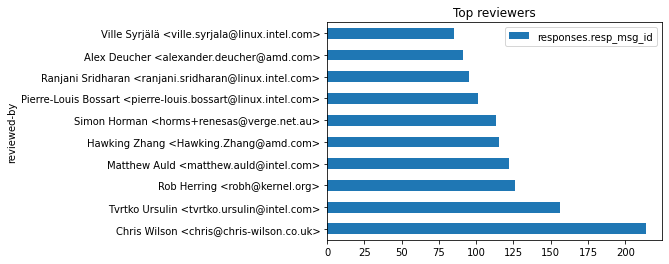

In [34]:
ax = patch_responses_long[['reviewed-by', 'responses.resp_msg_id']]\
                                    .groupby('reviewed-by')\
                                    .nunique()['responses.resp_msg_id']\
                                    .reset_index()\
                                    .sort_values('responses.resp_msg_id', ascending=False)[:10]\
                                    .plot(x ='reviewed-by', title= 'Top reviewers', kind = 'barh')
ax.figure.savefig('top_reviewers.png', dpi=1000, bbox_inches = "tight")   

Above are the top 20 reviewers who has sent the largest number of reviews. For these counts, every email which has a Reviewed-by tag is considered a review.

#### Development Groups

Who reviews patches from whom? Relationship among developers
Can we identify groups based on who authors patches and who reviews from each other? 

In [35]:
patch_responses_relations = patch_responses_long[['author', 'reviewed-by', 'responses.resp_msg_id']]\
                                    .groupby(['author', 'reviewed-by'])\
                                    .nunique()['responses.resp_msg_id']\
                                    .reset_index()
patch_responses_relations.head()

,author,reviewed-by,responses.resp_msg_id
0,"""Eric W. Biederman"" <ebiederm@xmission.com>",Thomas Gleixner <tglx@linutronix.de>,12
1,"""Huang, Ying"" <ying.huang@intel.com>",Andrea Parri <andrea.parri@amarulasolutions.com>,2
2,"""Huang, Ying"" <ying.huang@intel.com>",Andrew Morton <akpm@linux-foundation.org>,2
3,"""Mauro S. M. Rodrigues"" <maurosr@linux.vnet.ib...",Jesse Brandeburg <jesse.brandeburg@intel.com>,6
4,"""Yan, Zheng"" <zyan@redhat.com>",Jeff Layton <jlayton@redhat.com>,7


In [36]:
patch_responses_relations.to_csv('patch_responses_relations.csv')

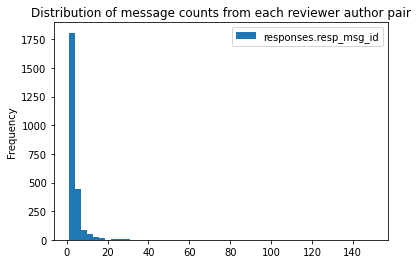

In [37]:
ax = patch_responses_relations.plot(kind = 'hist', 
                              title = 'Distribution of message counts from each reviewer author pair', 
                              bins = 50)
ax.figure.savefig('author_reviewer_reviewcount_dist.png', dpi=1000, bbox_inches = "tight")

### Among a group of authors and reviewers (within a cluster), how is authoring and reviewing distributed among the group of developers?

 To investigate relations between persons both from the groups of reviewers and developers, an undirected graph is created. Each node in the graph repsresent a person. Edges represent email exchange between two persons. Edges are weighted according to number of emails.

This graph demonstrates all of the reviews made in development process together with the authors of the patches that have been reviewed.

 The Louvain method for community detection is used to divide the graph into groups. Communities are represented with node colors in the visualization.

 For the sake of simplicity and readibility, only three levels of edge weights are shown in the visualization. Darker edges represent more email exchange.

In [38]:
# Create undirected graph with weighted edges

import networkx as nx

G=nx.Graph()

G.add_nodes_from(patch_responses_relations['reviewed-by'])
G.add_nodes_from(patch_responses_relations['author'])

G.add_weighted_edges_from(patch_responses_relations.values.tolist())

Determine partitioning

In [39]:
from community import community_louvain
partition = community_louvain.best_partition(G)

Create graph layout, refer to: https://stackoverflow.com/questions/21978487/improving-python-networkx-graph-layout

In [40]:
# pos = nx.kamada_kawai_layout(G)
pos = nx.nx_agraph.graphviz_layout(G)

Draw graph

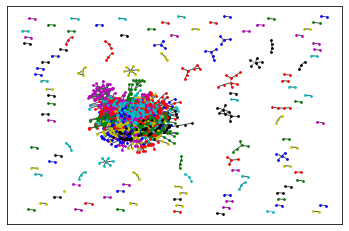

In [41]:
# import matplotlib.cm as cm
import itertools
import numpy as np

colors = itertools.cycle(['b', 'g', 'r', 'c', 'm', 'y', 'k'])

# size = float(len(set(partition.values())))
# Draw nodes, colored according to partitioning
count = 0.
for com in set(partition.values()) :
    count = count + 1.
    list_nodes = [nodes for nodes in partition.keys()
                                if partition[nodes] == com]
    nx.draw_networkx_nodes(G, pos, list_nodes, node_size = 3,
                        node_color = np.array([next(colors)]))
    edges, weights = zip(*nx.get_edge_attributes(G,'weight').items())

# To divide the edge weights into bins proportional to max
max_weight = max(weights)
# Divide edge weights into 3 categories
elarge = [(u, v) for (u, v, d) in G.edges(data=True) if d['weight'] >= 0.66*max_weight]
emedium = [(u, v) for (u, v, d) in G.edges(data=True) if d['weight'] >= 0.1*max_weight and  d['weight'] < 0.66*max_weight]
esmall = [(u, v) for (u, v, d) in G.edges(data=True) if d['weight'] < 0.1*max_weight]

# edges, 3 categories
nx.draw_networkx_edges(G, pos, edgelist=elarge, edge_color=str(1))
nx.draw_networkx_edges(G, pos, edgelist=emedium, edge_color=str(0.66))
nx.draw_networkx_edges(G, pos, edgelist=esmall, edge_color=str(0.33))

# edges, the darker, the greater weight
# nx.draw_networkx_edges(G, pos, edgelist=edges, edge_color=weights, edge_cmap=cm.Greys)

# If we want labels for each person:
# nx.draw_networkx_labels(G, pos, font_size = 1)

fig1 = plt.gcf()
plt.show()
plt.draw()
fig1.savefig('plot_mails.png', dpi=1000, bbox_inches = "tight")

In [42]:
del patch_responses_relations

<Figure size 432x288 with 0 Axes>

### Maintainers, reviewers and patch authors

In [9]:
from pypasta.LinuxMaintainers import LinuxMaintainers
from pypasta.Util import file_to_string
from pypasta.Repository.Repository import Repository

def pretty_name(maintainer):
    try:
        if isinstance(maintainer, str):
            return None
        else:
            return '"' + maintainer[0][:-1] + '"' + ' <'+maintainer[1]+'>'
    except:
        # Return None when it is a mailing list or it is empty 
        return None

def flatten(nested_list):
    return [item for sublist in nested_list for item in sublist]

f_maintainers = file_to_string('./resources/linux/repo/MAINTAINERS')
all_maintainers = LinuxMaintainers(f_maintainers)
repo = Repository('./resources/linux/repo')

def get_maintainer(upstream):
    try:
        maintainers = []
        filenames = repo.get_commit(upstream).diff.affected
        subsystems = all_maintainers.get_subsystems_by_files(filenames)            
        for subsystem in subsystems:
            maintainers += all_maintainers.get_maintainers(subsystem)
        maintainers = {pretty_name(maintainer) for maintainer in flatten(maintainers)}
        return list(maintainers)
    except:
        return None

Oo: 	Documentation/devicetree/bindings/media/ti,cal.yaml


In [24]:
# patch_responses_long = pd.read_csv('df_with_tags.csv')

/home/bmw/basak/PaStA/mail_tags/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3062: DtypeWarning: Columns (9) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [25]:
maintainer = patch_responses_long[['upstream', 'author', 'reviewed-by', 'responses.resp_msg_id']]

In [26]:
del patch_responses_long

In [27]:
maintainer['maintainer'] = maintainer['upstream'].apply(get_maintainer)

In [28]:
maintainer.set_index(['upstream', 'author', 'reviewed-by', 'responses.resp_msg_id'], inplace=True)

In [29]:
maintainer = pd.melt(maintainer['maintainer'].apply(pd.Series).reset_index(), 
            id_vars=['upstream', 'author', 'reviewed-by', 'responses.resp_msg_id'],
            value_name='maintainer').sort_index()
maintainer.drop('variable', axis=1, inplace=True)
maintainer = maintainer.dropna(how='all')

It takes some time to get maintainers from hashes, even for smaller samples. I save my previous results and start from there for analysis.

In [30]:
maintainer.to_csv('maintainer.csv')
# import pandas as pd
# maintainer = pd.read_csv('maintainer.csv', 
#                          usecols=['upstream', 'author', 'reviewed-by', 'responses.resp_msg_id', 'maintainer'],
#                          dtype = {'upstream':str, 'author':str, 'reviewed-by':str, 
#                                   'responses.resp_msg_id':str, 'maintainer':str})

In [31]:
maintainer.head()

,upstream,author,reviewed-by,responses.resp_msg_id,maintainer
0,NaN,NaN,NaN,<CAEf4BzYTGuXgN+vNJEoMbH_GFAVnSsBvq_YhvoFOeGG5...,NaN
1,NaN,NaN,NaN,<CAEf4BzYTGuXgN+vNJEoMbH_GFAVnSsBvq_YhvoFOeGG5...,NaN
2,NaN,NaN,NaN,<CAEf4BzYTGuXgN+vNJEoMbH_GFAVnSsBvq_YhvoFOeGG5...,NaN
3,NaN,NaN,NaN,<CAEf4BzabgRE6qZChfw=7nptxYAyZFcj0+Jk_PMSZQP0Z...,NaN
4,NaN,NaN,NaN,<CAEf4BzYTGuXgN+vNJEoMbH_GFAVnSsBvq_YhvoFOeGG5...,NaN


In [32]:
counts = maintainer.groupby('responses.resp_msg_id').nunique()
counts.head()

,upstream,author,reviewed-by,responses.resp_msg_id,maintainer
responses.resp_msg_id,,,,,
<-hr0cw7wplji6kur9szo2dka8ja1pou-3nnay4-uxxtwr-otnhsl1qetv0o1gtgu-lfnxxj8heoqc6a8l96-nzvfofweuygaoki3ql-641t1t-lccynh6ltsf-lty877-volmoddqo3n1-k65ryocb6ryt.1558004857725@email.android.com>,0,0,0,1,0
<-puwqkvl1kf9u-b7x3md-nw9l5d8fjhc1-57ay9i80p3ne5zfq-v36laytxxssb-707g2imrn1o7-kvonq5nbuaig-6dlanc9wrlar1w0zlrxn0apu-qaxsb6-ac864zux0f2o3d8y3zq369i3-f7fg8.1558613478804@email.android.com>,0,0,0,1,0
<-vf7xt3-qgf5mz-veq8ih-okgxtz-9ehg3tx8dyemoidihe-fwj066fntvvx-x3y4nh-bn07hl-82anfo4oofx-4di7gg-3nkfhtbcgh58-yj9ws0-pthytc-oq9qcxd40s4g-249dv8-x6wbfujry6xi-mu2nvl.1557839540398@email.android.com>,0,0,0,1,0
<-wsx1tz-kxfbz1yns7x33sra134gl11xhlux4lx3izissqr2httt4mb1vleyxgj8i7k6-q6ze8ub3ff8c4o0fxmx7niu76yg4-ybakue-3v14jw-ed5ol8ybh6o9-1ze886-hbstfi448pvq3pwhkj.1557844282594@email.android.com>,0,0,0,1,0
<-yd30ko-7yy2hg-rmre4orxyza7-xndome2qdx81-wtzk8a-eccw2rc52fs2-grqgt7bajdlk-5lgjxo-xu3otx-5m9i78-2xa184-z2lana96yogmoisk45t18dyy9462b5f86c1cg5hlpw-xorlqm-lev8gs.1557413178321@email.android.com>,0,0,0,1,0


In [33]:
maintainer[maintainer['maintainer'] == maintainer['reviewed-by']]

,upstream,author,reviewed-by,responses.resp_msg_id,maintainer


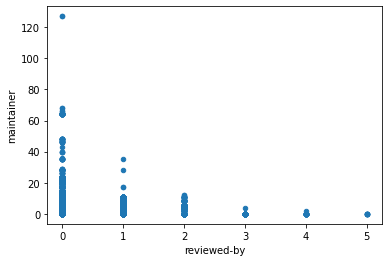

In [34]:
counts.plot.scatter('reviewed-by', 'maintainer')

Messages where one of maintainers is the patch author

In [35]:
maintainer[maintainer['maintainer'] == maintainer['author']]

,upstream,author,reviewed-by,responses.resp_msg_id,maintainer


Number of emails in each maintainer's area

In [36]:
maintainer.groupby(['maintainer']).nunique()['responses.resp_msg_id'].sort_values(ascending=False)

maintainer
"linus torvalds" <torvalds@linux-foundation.org>           35652
"maxime ripard" <mripard@kernel.org>                        7560
"david airlie" <airlied@linux.ie>                           7397
"daniel vetter" <daniel@ffwll.ch>                           7397
"maarten lankhorst" <maarten.lankhorst@linux.intel.com>     7259
                                                           ...  
"bryan whitehead" <bryan.whitehead@microchip.com>              1
"jesper nilsson" <jesper.nilsson@axis.com>                     1
"andreas koensgen" <ajk@comnets.uni-bremen.de>                 1
"peter ujfalusi" <peter.ujfalusi@ti.com>                       1
"åukasz stelmach" <l.stelmach@samsung.com>                    1
Name: responses.resp_msg_id, Length: 1037, dtype: int64

Number of emails from each reviewer, for comparison

In [37]:
maintainer.groupby(['reviewed-by']).nunique()['responses.resp_msg_id'].sort_values(ascending=False)

reviewed-by
Chris Wilson <chris@chris-wilson.co.uk>                 214
Tvrtko Ursulin <tvrtko.ursulin@intel.com>               156
Rob Herring <robh@kernel.org>                           126
Matthew Auld <matthew.auld@intel.com>                   122
Hawking Zhang <Hawking.Zhang@amd.com>                   115
                                                       ... 
Karsten Merker <merker@debian.org>                        1
Kuninori Morimoto <kuninori.morimoto.gx@renesas.com>      1
Laszlo Ersek <lersek@redhat.com>                          1
Leonard Foerster <foersleo@amazon.de>                     1
"Martin K. Petersen" <martin.petersen@oracle.com>         1
Name: responses.resp_msg_id, Length: 931, dtype: int64

Messages where one of maintainers is the reviewer

In [38]:
maintainer[maintainer['maintainer'] == maintainer['reviewed-by']]

,upstream,author,reviewed-by,responses.resp_msg_id,maintainer


The maintainers are detected for a very limited subset of the dataset, as we only ĺook at upstreams that ended up in the repo, this could possibly explain not getting any results above.